# This is a notebook for querying the World Ocean Database instance for the 1.0.0 Beacon release.

-   You can run each cell individually by pressing "shift + enter".
-   For more information, questions, bugs, please contact us on Slack:
    -   https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2dp1vv56r-tj_KFac0sAKNuAgUKPPDRg.

# Documentation for querying Beacon can be found here:
- https://maris-development.github.io/beacon/docs/1.0.1/query-docs/querying/json.html


#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token between the " " in the cell below.


In [ ]:
TOKEN = ""
BEACON_INSTANCE_URL = "https://beacon-wod.maris.nl"

In [12]:
# Installing the required libraries
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install xarray
%pip install netCDF4
%pip install pandas
%pip install --upgrade cartopy
%pip install scipy
%pip install pyarrow


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: netCDF4 in c:\python\lib\site-packages (1.5.8)




[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import the required packages


In [13]:
import requests
import json
from io import BytesIO
import xarray as xr
import datetime
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings

### Beacon Status Check


In [14]:
response = requests.get(
    f"{BEACON_INSTANCE_URL}/api/health",
    headers={"Authorization": f"Bearer {TOKEN}"},
)
if response.status_code == 200:
    print("Beacon is up and running.")
else:
    print("Beacon is down or not reachable.")
    exit()

Beacon is up and running.


In [15]:
responseinfo = requests.get(f"{BEACON_INSTANCE_URL}/api/query/available-columns", headers = {"Authorization" : f"Bearer {TOKEN}"}) 
params = responseinfo.json()

#### Below you can search through the available columns by entering text between the brackets of search_columns(" ").


In [16]:
def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in params if search_term in col.lower()]
    
    if matches:
        print("Matching columns:")
        for match in matches:
            print(match)
    else:
        print("No matching columns found.")

search_columns("time") #Enter your search term here

Matching columns:
time
time.standard_name
time.long_name
time.units
time.axis
GMT_time
GMT_time.long_name
real_time
real_time.long_name
real_time.comment
GMT_sample_start_time
GMT_sample_start_time.long_name
GMT_sample_start_time.units
GMT_sample_start_time.comment
PrimaryProd_Incubation Time
PrimaryProd_Incubation Time.units
PrimaryProd_Incubation Time.comment
I_Incubation_time
I_Incubation_time.long_name
I_Incubation_time.comment
I_start_time
I_start_time.long_name
I_start_time.units
I_start_time.comment
Chlorophyll_Incubation Time
Chlorophyll_Incubation Time.units
Chlorophyll_Incubation Time.comment


#### You can define here your input parameters


In [17]:
parameter = "Temperature" #column name 
mindate = "2010-01-01" #yyyy-mm-dd
maxdate = "2011-01-01" #yyyy-mm-dd
minlon = -180
maxlon = 180
minlat = -90
maxlat = 90
mindepth = 0
maxdepth = 10

create_netcdf = True #True or False
create_parquet = True #True or False

#### This will create the query body based on your input parameters, you can add other "query_parameters" and "filters" to suit your needs.

-   For more query examples and explanations, you can take a look at https://maris-development.github.io/beacon/.


In [22]:
query = {
    "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter,
            },
            {
                "column_name": "time",
                "alias": "TIME",
            },
            {
                "column_name": "z",
                "alias": "DEPTH"
            },
            {
                "column_name": "lon",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "lat",
                "alias": "LATITUDE"
            },
            {
                "column_name": "dataset",
                "alias": "dataset",
            },
        ],
        "filters": [
            {
                "for_query_parameter": "TIME",
                "min": f"{mindate}T00:00:00",
                "max": f"{maxdate}T00:00:00",
            },
            {
                "for_query_parameter": "DEPTH",
                "min": mindepth,
                "max": maxdepth
            },
            {
                "for_query_parameter": "LONGITUDE",
                "min": minlon,
                "max": maxlon
            },
            {
                "for_query_parameter": "LATITUDE",
                "min": minlat,
                "max": maxlat
            },
            {
                "is_not_null": {
                    "for_query_parameter": parameter,
                }
            },
            {
                "for_query_parameter": parameter,
                "neq": -10000000000 # This is the value used for missing data in the WOD as they don't store a fill attribute in their original data
            }
        ],
        "output": {
            "format": "parquet"
        }
}

#### This is the post request that is sent to Beacon with the above specified body.


In [23]:
response = requests.post(f"{BEACON_INSTANCE_URL}/api/query", json.dumps(query), headers = {
    "Authorization" : f"Bearer {TOKEN}",
    "Content-type": "application/json"
})

if response.status_code != 200:
    print(response.text)
    print("An error occurred while processing your request. Please check your input fields and try again.")
    
# Save the response to a BytesIO object
bytes_io = BytesIO(response.content)
df = pd.read_parquet(bytes_io)
# We have to convert the time column from seconds 1970 to datetime64[ns] type
df['TIME'] = pd.to_datetime(df['TIME'], unit='s')
df

,Temperature,TIME,DEPTH,LONGITUDE,LATITUDE,dataset
0,25.384001,2010-01-13 16:55:18,5.465226,74.068001,-23.218000,profiling float
1,25.264000,2010-01-13 16:55:18,8.943021,74.068001,-23.218000,profiling float
2,25.632000,2010-01-03 17:09:21,5.465179,73.614998,-23.346001,profiling float
3,25.625999,2010-01-03 17:09:21,8.942945,73.614998,-23.346001,profiling float
4,25.624001,2010-01-12 17:00:57,5.464930,76.667000,-24.018000,profiling float
...,...,...,...,...,...,...
2430081,21.959999,2010-01-03 06:34:59,6.000000,164.979996,29.014999,XCTD
2430082,21.950001,2010-01-02 14:37:00,6.000000,164.979996,30.052999,XCTD
2430083,21.500000,2010-01-02 07:48:59,6.000000,165.031006,30.999001,XCTD
2430084,20.040001,2010-01-01 16:15:59,6.000000,165.098999,32.026001,XCTD


### Create output files (NetCDF and/or Parquet) with the results of the query

In [24]:
if not os.path.exists("./Beacon_V1.0.0_Output"):
    os.makedirs("Beacon_V1.0.0_Output")

def generate_file_name(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, extension):
    regionname = f"[{minlat}_{minlon}]_[{maxlat}_{maxlon}]" 
    file_name = f"{parameter}_{regionname}_{mindate}_{maxdate}_[{mindepth}_{maxdepth}m].{extension}"
    return file_name

# Save the DataFrame to file formats
if create_parquet:
    parquet_file_name = generate_file_name(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, "parquet")
    df.to_parquet(f"./Beacon_V1.0.0_Output/{parquet_file_name}", index=False)
    print(f"Data saved to {parquet_file_name}")
    
if create_netcdf:
    netcdf_file_name = generate_file_name(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, "nc")
    xr_data = df.to_xarray()
    xr_data.to_netcdf(f"./Beacon_V1.0.0_Output/{netcdf_file_name}")
    print(f"Data saved to {netcdf_file_name}")

Data saved to Temperature_[-90_-180]_[90_180]_2010-01-01_2011-01-01_[0_10m].parquet
Data saved to Temperature_[-90_-180]_[90_180]_2010-01-01_2011-01-01_[0_10m].nc


#### Plotting of results


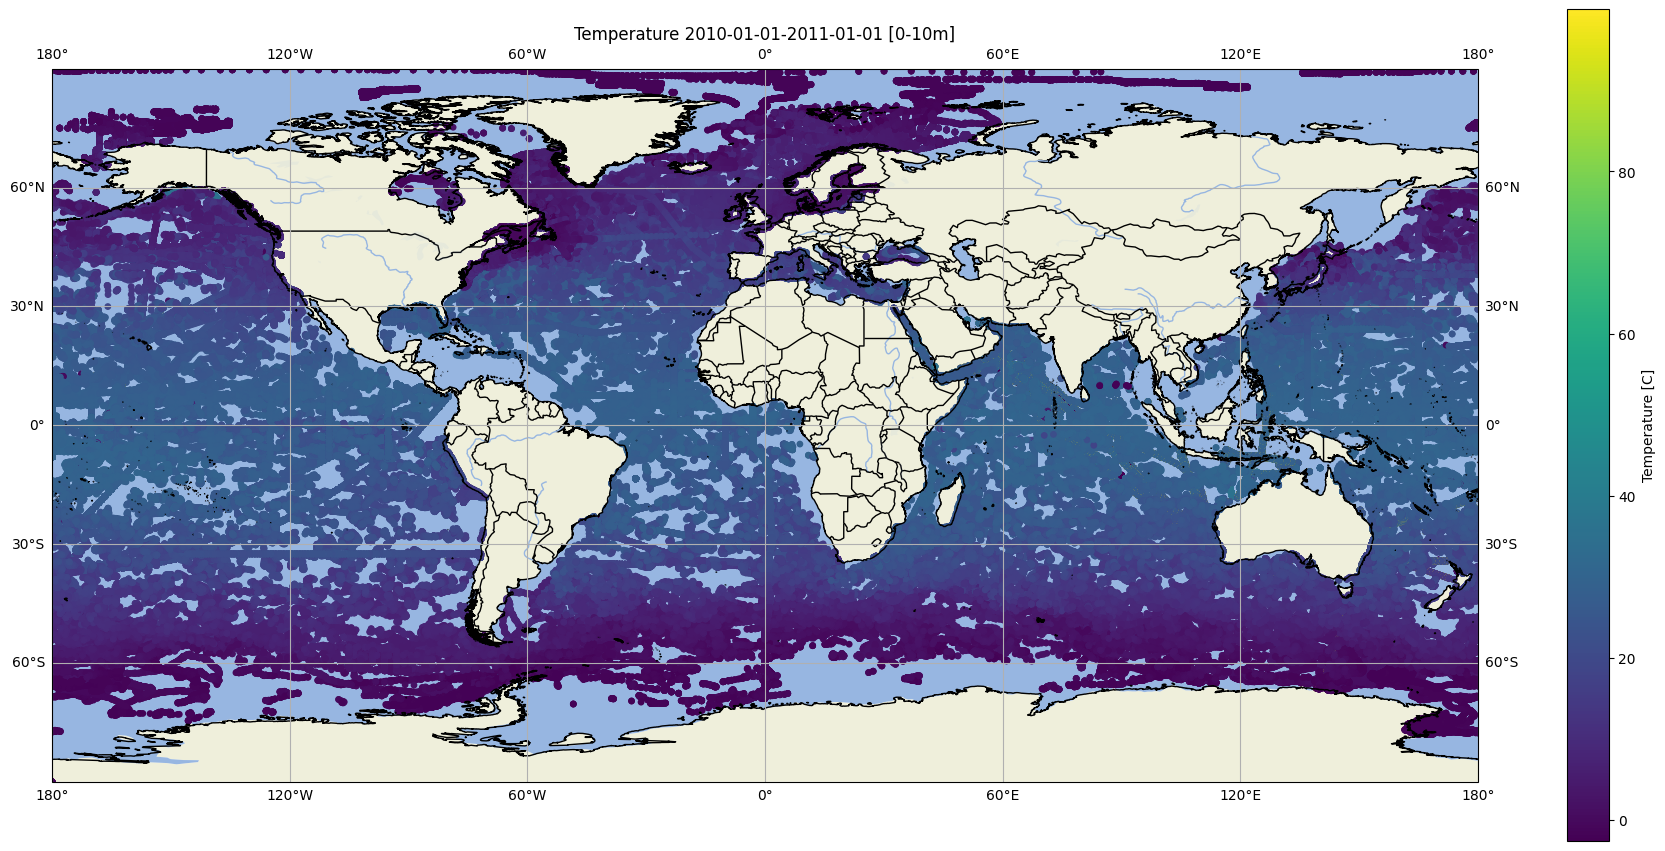

In [25]:
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="viridis", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"{parameter} [C]")

plt.title(f"{parameter} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")

plt.show()